In [ ]:
import tensorflow as tf

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random 
import os
import PIL.Image
import cv2
import random
from PIL import Image

In [ ]:
url = 'https://storage.googleapis.com/download.tensorflow.org/example_images/YellowLabradorLooking_new.jpg'

98304/83281 [===================================] - 0s 0us/step


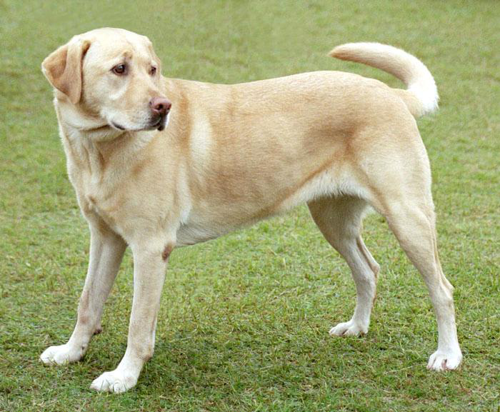

In [ ]:
# Download an image and read it into a NumPy array.
def download(url, max_dim=None):
  name = url.split('/')[-1]
  image_path = tf.keras.utils.get_file(name, origin=url)
  img = PIL.Image.open(image_path)
  if max_dim:
    img.thumbnail((max_dim, max_dim))
  return np.array(img)

# Normalize an image
def deprocess(img):
  img = 255*(img + 1.0)/2.0
  return tf.cast(img, tf.uint8)

# Display an image
def show(img):
  display.display(PIL.Image.fromarray(np.array(img)))


# Downsizing the image makes it easier to work with.
original_img = download(url, max_dim=500)
show(original_img)
display.display(display.HTML('Image cc-by: <a "href=https://commons.wikimedia.org/wiki/File:Felis_catus-cat_on_snow.jpg">Von.grzanka</a>'))

In [ ]:
base_model = tf.keras.applications.InceptionV3(include_top=False, weights='imagenet')

87924736/87910968 [==============================] - 0s 0us/step


In [ ]:
# Maximize the activations of these layers
names = ['mixed3', 'mixed5']
layers = [base_model.get_layer(name).output for name in names]

# Create the feature extraction model
dream_model = tf.keras.Model(inputs=base_model.input, outputs=layers)

In [ ]:
def calc_loss(img, model):
  # Pass forward the image through the model to retrieve the activations.
  # Converts the image into a batch of size 1.
  img_batch = tf.expand_dims(img, axis=0)
  layer_activations = model(img_batch)
  if len(layer_activations) == 1:
    layer_activations = [layer_activations]

  losses = []
  for act in layer_activations:
    loss = tf.math.reduce_mean(act)
    losses.append(loss)

  return  tf.reduce_sum(losses)

In [ ]:
class DeepDream(tf.Module):
  def __init__(self, model):
    self.model = model

  @tf.function(
      input_signature=(
        tf.TensorSpec(shape=[None,None,3], dtype=tf.float32),
        tf.TensorSpec(shape=[], dtype=tf.int32),
        tf.TensorSpec(shape=[], dtype=tf.float32),)
  )
  def __call__(self, img, steps, step_size):
      print("Tracing")
      loss = tf.constant(0.0)
      for n in tf.range(steps):
        with tf.GradientTape() as tape:
          # This needs gradients relative to `img`
          # `GradientTape` only watches `tf.Variable`s by default
          tape.watch(img)
          loss = calc_loss(img, self.model)

        # Calculate the gradient of the loss with respect to the pixels of the input image.
        gradients = tape.gradient(loss, img)

        # Normalize the gradients.
        gradients /= tf.math.reduce_std(gradients) + 1e-8 
        
        # In gradient ascent, the "loss" is maximized so that the input image increasingly "excites" the layers.
        # You can update the image by directly adding the gradients (because they're the same shape!)
        img = img + gradients*step_size
        img = tf.clip_by_value(img, -1, 1)

      return loss, img

In [ ]:
deepdream = DeepDream(dream_model)

In [ ]:
def run_deep_dream_simple(img, steps=100, step_size=0.01):
  # Convert from uint8 to the range expected by the model.
  img = tf.keras.applications.inception_v3.preprocess_input(img)
  img = tf.convert_to_tensor(img)
  step_size = tf.convert_to_tensor(step_size)
  steps_remaining = steps
  step = 0
  while steps_remaining:
    if steps_remaining>100:
      run_steps = tf.constant(100)
    else:
      run_steps = tf.constant(steps_remaining)
    steps_remaining -= run_steps
    step += run_steps

    loss, img = deepdream(img, run_steps, tf.constant(step_size))
    
    display.clear_output(wait=True)
    show(deprocess(img))
    print ("Step {}, loss {}".format(step, loss))


  result = deprocess(img)
  display.clear_output(wait=True)
  show(result)

  return result

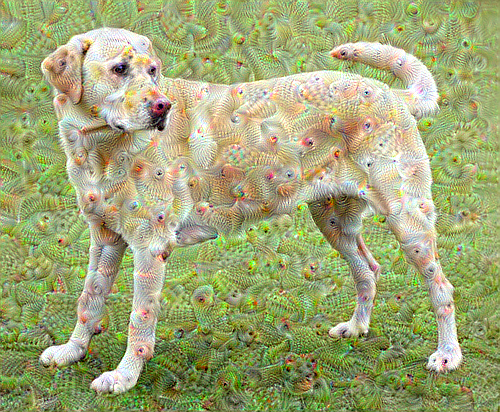

In [ ]:
dream_img = run_deep_dream_simple(img=original_img, 
                                  steps=100, step_size=0.01)

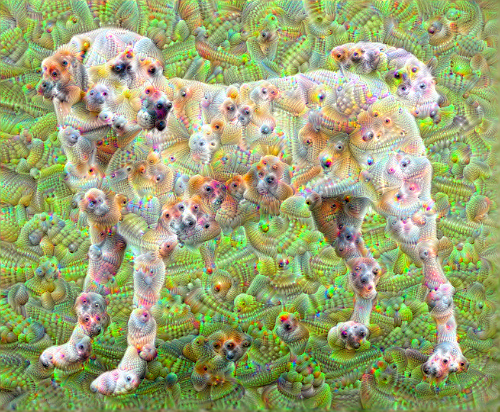

17.63354182243347

In [ ]:
import time
start = time.time()

OCTAVE_SCALE = 1.30

img = tf.constant(np.array(original_img))
base_shape = tf.shape(img)[:-1]
float_base_shape = tf.cast(base_shape, tf.float32)

for n in range(-2, 3):
  new_shape = tf.cast(float_base_shape*(OCTAVE_SCALE**n), tf.int32)

  img = tf.image.resize(img, new_shape).numpy()

  img = run_deep_dream_simple(img=img, steps=50, step_size=0.01)

display.clear_output(wait=True)
img = tf.image.resize(img, base_shape)
img = tf.image.convert_image_dtype(img/255.0, dtype=tf.uint8)
show(img)

end = time.time()
end-start

In [ ]:
def random_roll(img, maxroll):
  # Randomly shift the image to avoid tiled boundaries.
  shift = tf.random.uniform(shape=[2], minval=-maxroll, maxval=maxroll, dtype=tf.int32)
  img_rolled = tf.roll(img, shift=shift, axis=[0,1])
  return shift, img_rolled

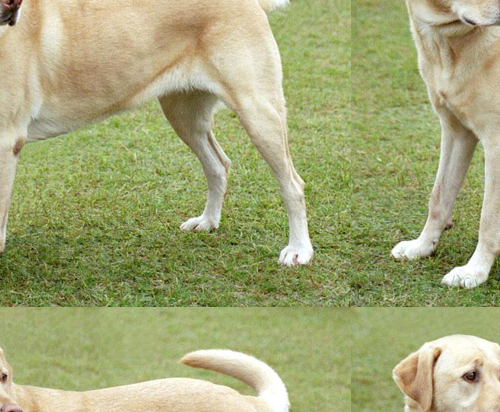

In [ ]:
shift, img_rolled = random_roll(np.array(original_img), 512)
show(img_rolled)

In [ ]:
class TiledGradients(tf.Module):
  def __init__(self, model):
    self.model = model

  @tf.function(
      input_signature=(
        tf.TensorSpec(shape=[None,None,3], dtype=tf.float32),
        tf.TensorSpec(shape=[2], dtype=tf.int32),
        tf.TensorSpec(shape=[], dtype=tf.int32),)
  )
  def __call__(self, img, img_size, tile_size=512):
    shift, img_rolled = random_roll(img, tile_size)

    # Initialize the image gradients to zero.
    gradients = tf.zeros_like(img_rolled)
    
    # Skip the last tile, unless there's only one tile.
    xs = tf.range(0, img_size[1], tile_size)[:-1]
    if not tf.cast(len(xs), bool):
      xs = tf.constant([0])
    ys = tf.range(0, img_size[0], tile_size)[:-1]
    if not tf.cast(len(ys), bool):
      ys = tf.constant([0])

    for x in xs:
      for y in ys:
        # Calculate the gradients for this tile.
        with tf.GradientTape() as tape:
          # This needs gradients relative to `img_rolled`.
          # `GradientTape` only watches `tf.Variable`s by default.
          tape.watch(img_rolled)

          # Extract a tile out of the image.
          img_tile = img_rolled[y:y+tile_size, x:x+tile_size]
          loss = calc_loss(img_tile, self.model)

        # Update the image gradients for this tile.
        gradients = gradients + tape.gradient(loss, img_rolled)

    # Undo the random shift applied to the image and its gradients.
    gradients = tf.roll(gradients, shift=-shift, axis=[0,1])

    # Normalize the gradients.
    gradients /= tf.math.reduce_std(gradients) + 1e-8 

    return gradients 

In [ ]:
get_tiled_gradients = TiledGradients(dream_model)

In [ ]:
def run_deep_dream_with_octaves(img, steps_per_octave=100, step_size=0.01, 
                                octaves=range(-2,3), octave_scale=1.3):
  base_shape = tf.shape(img)
  img = tf.keras.utils.img_to_array(img)
  img = tf.keras.applications.inception_v3.preprocess_input(img)

  initial_shape = img.shape[:-1]
  img = tf.image.resize(img, initial_shape)
  for octave in octaves:
    # Scale the image based on the octave
    new_size = tf.cast(tf.convert_to_tensor(base_shape[:-1]), tf.float32)*(octave_scale**octave)
    new_size = tf.cast(new_size, tf.int32)
    img = tf.image.resize(img, new_size)

    for step in range(steps_per_octave):
      gradients = get_tiled_gradients(img, new_size)
      img = img + gradients*step_size
      img = tf.clip_by_value(img, -1, 1)

      if step % 10 == 0:
        display.clear_output(wait=True)
        show(deprocess(img))
        print ("Octave {}, Step {}".format(octave, step))
    
  result = deprocess(img)
  return result

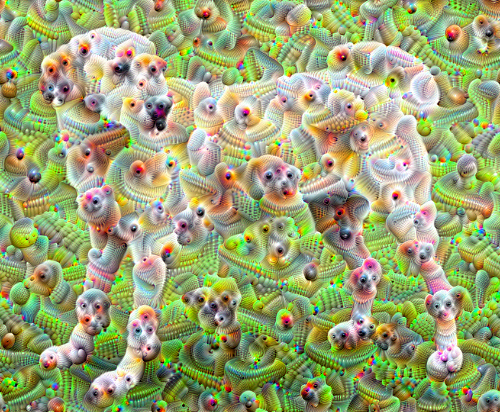

In [ ]:
img = run_deep_dream_with_octaves(img=original_img, step_size=0.01)

display.clear_output(wait=True)
img = tf.image.resize(img, base_shape)
img = tf.image.convert_image_dtype(img/255.0, dtype=tf.uint8)
show(img)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
image = tf.keras.preprocessing.image.load_img("/content/drive/MyDrive/mars_eiffel/img_0.jpg")

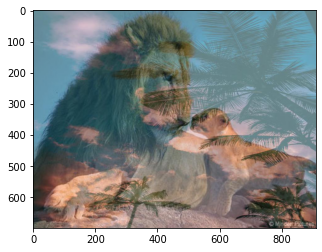

In [ ]:
plt.imshow(image)

In [ ]:
dream_name = 'mars_eiffel'

In [ ]:
# Blended image dimension

x_size = 910 # larger the image longer is going to take to fetch the frames 
y_size = 605

In [ ]:
# Define Counters 
created_count = 0
max_count = 50

In [ ]:
def load_image(filename):
    image = PIL.Image.open(filename)
    return np.float32(image)

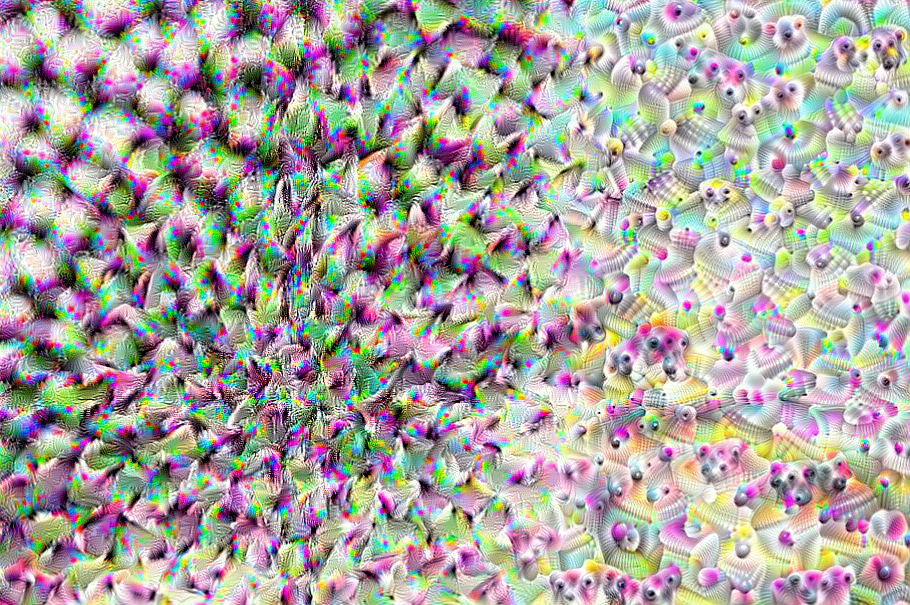

In [ ]:
for i in range(0, 50):
    # Make sure to create a new folder entitled 'mars_eiffel' and place img_0 in it
    # Get into the dream directory and look for the number of images and then figure out what is the latest image. Hence this 
    # image we are going to start with and let it dream on and on
     
    if os.path.isfile('/content/drive/MyDrive/mars_eiffel/img_{}.jpg'.format(i+1)):
        print("{} present already, continue fetching the frames...".format(i+1))
        
    else:
        # Call the load image funtion
        img_result = load_image(r'/content/drive/MyDrive/mars_eiffel/img_{}.jpg'.format(i))

    
        # Zoom the image 
        x_zoom = 2 # this indicates how quick the zoom is 
        y_zoom = 1
        
        # Chop off the edges of the image and resize the image back to the original shape. This gives the visual changes of a zoom
        img_result = img_result[0+x_zoom : y_size-y_zoom, 0+y_zoom : x_size-x_zoom]
        img_result = cv2.resize(img_result, (x_size, y_size))
        
        # Adjust the RGB value of the image
        img_result[:, :, 0] += 2  # red
        img_result[:, :, 1] += 2  # green
        img_result[:, :, 2] += 2  # blue
        
        # Deep dream model  
        img_result = run_deep_dream_simple(img = img_result, steps = 500, step_size = 0.001)
        
        # Clip the image, convert the datatype of the array, and then convert to an actual image. 
        img_result = np.clip(img_result, 0.0, 255.0)
        img_result = img_result.astype(np.uint8)
        result = PIL.Image.fromarray(img_result, mode='RGB')
        
        # Save all the frames in the dream location
        result.save(r'/content/drive/MyDrive/mars_eiffel/img_{}.jpg'.format(i+1))
        
        created_count += 1
        if created_count > max_count:
            break

In [ ]:
import os

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving mars_eiffel-20220228T143943Z-001.zip to mars_eiffel-20220228T143943Z-001.zip


In [ ]:
# Unzip the folder

from zipfile import ZipFile
file_name = "mars_eiffel-20220228T143943Z-001.zip"

with ZipFile(file_name, 'r') as zip:
  zip.extractall()
  print('Done')

Done


In [ ]:

dream_path = 'mars_eiffel'

In [ ]:
# Define the codec and create VideoWriter object 
# Download FFmeg 

fourcc = cv2.VideoWriter_fourcc(*'XVID') # FourCC is a 4-byte code used to specify the video codec

out = cv2.VideoWriter('deepdreamvideo.avi', fourcc , 5.0, (910, 605)) # Specify the fourCC, frames per second (fps),
                                                                            # and frame size
# The frames per second value is depends on few important things
# 1. The number of frames we have created. Less number of frames brings small fps
# 2. The larger the image the bigger the fps value. For example, 1080 pixel image can bring 60 fps 

In [ ]:
for i in range(9999999999999):
    
    # Get into the dream directory and looks for the number of images and then figure out what is the latest image. Hence with 
    # this image we are going to start with and let it dream on and on
    if os.path.isfile('mars_eiffel/img_{}.jpg'.format(i+1)):
        pass
    # Figure out how long the dream is 
    else:
        dream_length = i
        break

In [ ]:
dream_length

50

In [ ]:
for i in range(dream_length):
    
    # Build the frames of cv2.VideoWriter
    img_path = os.path.join(dream_path,'img_{}.jpg'.format(i)) # join the dream path
    
    print(img_path) # print the image path 
    
    frame = cv2.imread(img_path)
    out.write(frame)

out.release()

mars_eiffel/img_0.jpg
mars_eiffel/img_1.jpg
mars_eiffel/img_2.jpg
mars_eiffel/img_3.jpg
mars_eiffel/img_4.jpg
mars_eiffel/img_5.jpg
mars_eiffel/img_6.jpg
mars_eiffel/img_7.jpg
mars_eiffel/img_8.jpg
mars_eiffel/img_9.jpg
mars_eiffel/img_10.jpg
mars_eiffel/img_11.jpg
mars_eiffel/img_12.jpg
mars_eiffel/img_13.jpg
mars_eiffel/img_14.jpg
mars_eiffel/img_15.jpg
mars_eiffel/img_16.jpg
mars_eiffel/img_17.jpg
mars_eiffel/img_18.jpg
mars_eiffel/img_19.jpg
mars_eiffel/img_20.jpg
mars_eiffel/img_21.jpg
mars_eiffel/img_22.jpg
mars_eiffel/img_23.jpg
mars_eiffel/img_24.jpg
mars_eiffel/img_25.jpg
mars_eiffel/img_26.jpg
mars_eiffel/img_27.jpg
mars_eiffel/img_28.jpg
mars_eiffel/img_29.jpg
mars_eiffel/img_30.jpg
mars_eiffel/img_31.jpg
mars_eiffel/img_32.jpg
mars_eiffel/img_33.jpg
mars_eiffel/img_34.jpg
mars_eiffel/img_35.jpg
mars_eiffel/img_36.jpg
mars_eiffel/img_37.jpg
mars_eiffel/img_38.jpg
mars_eiffel/img_39.jpg
mars_eiffel/img_40.jpg
mars_eiffel/img_41.jpg
mars_eiffel/img_42.jpg
mars_eiffel/img_43.jp